In [2]:
import pandas as pd

# Load the Excel file (reads the first sheet by default)
excel_file = 'raw_sales_data.xlsx'  # Replace with your actual file name
df = pd.read_excel(excel_file)

# Save the DataFrame to a CSV file
csv_file = 'raw_sales_data.csv'
df.to_csv(csv_file, index=False)

print(f"Excel file '{excel_file}' has been converted to '{csv_file}'")


Excel file 'raw_sales_data.xlsx' has been converted to 'raw_sales_data.csv'


✅ Missing values handled using mean (numerical) and mode (categorical).


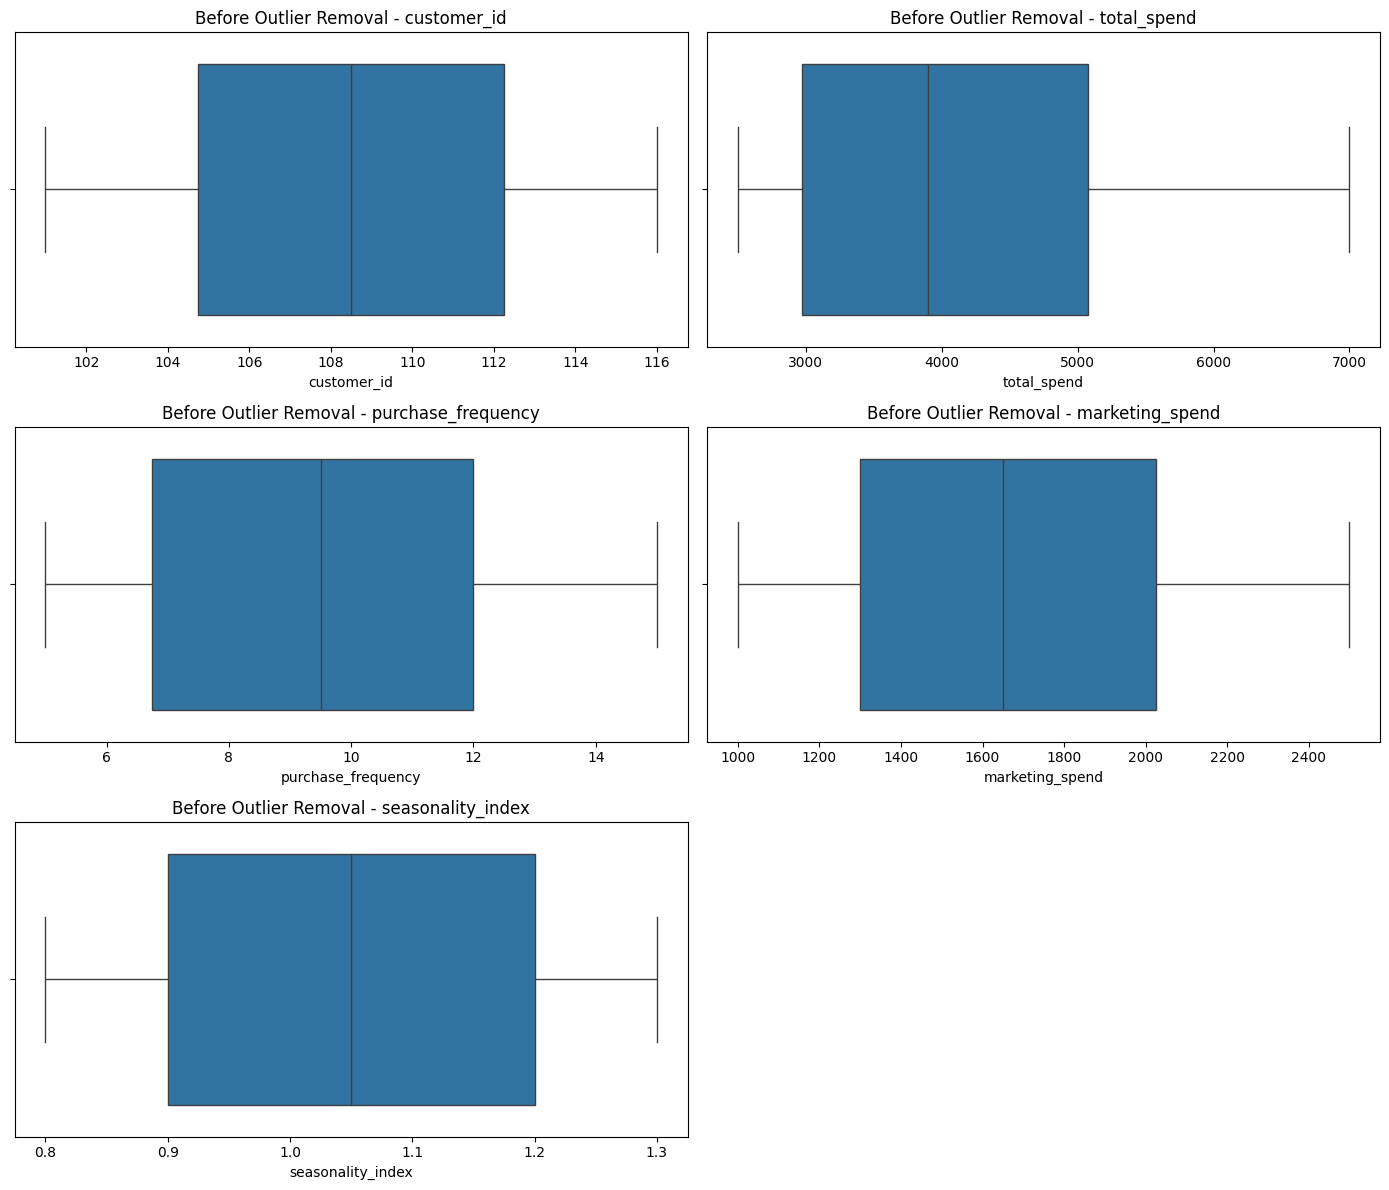

✅ Outliers removed. Rows reduced from 16 to 16.


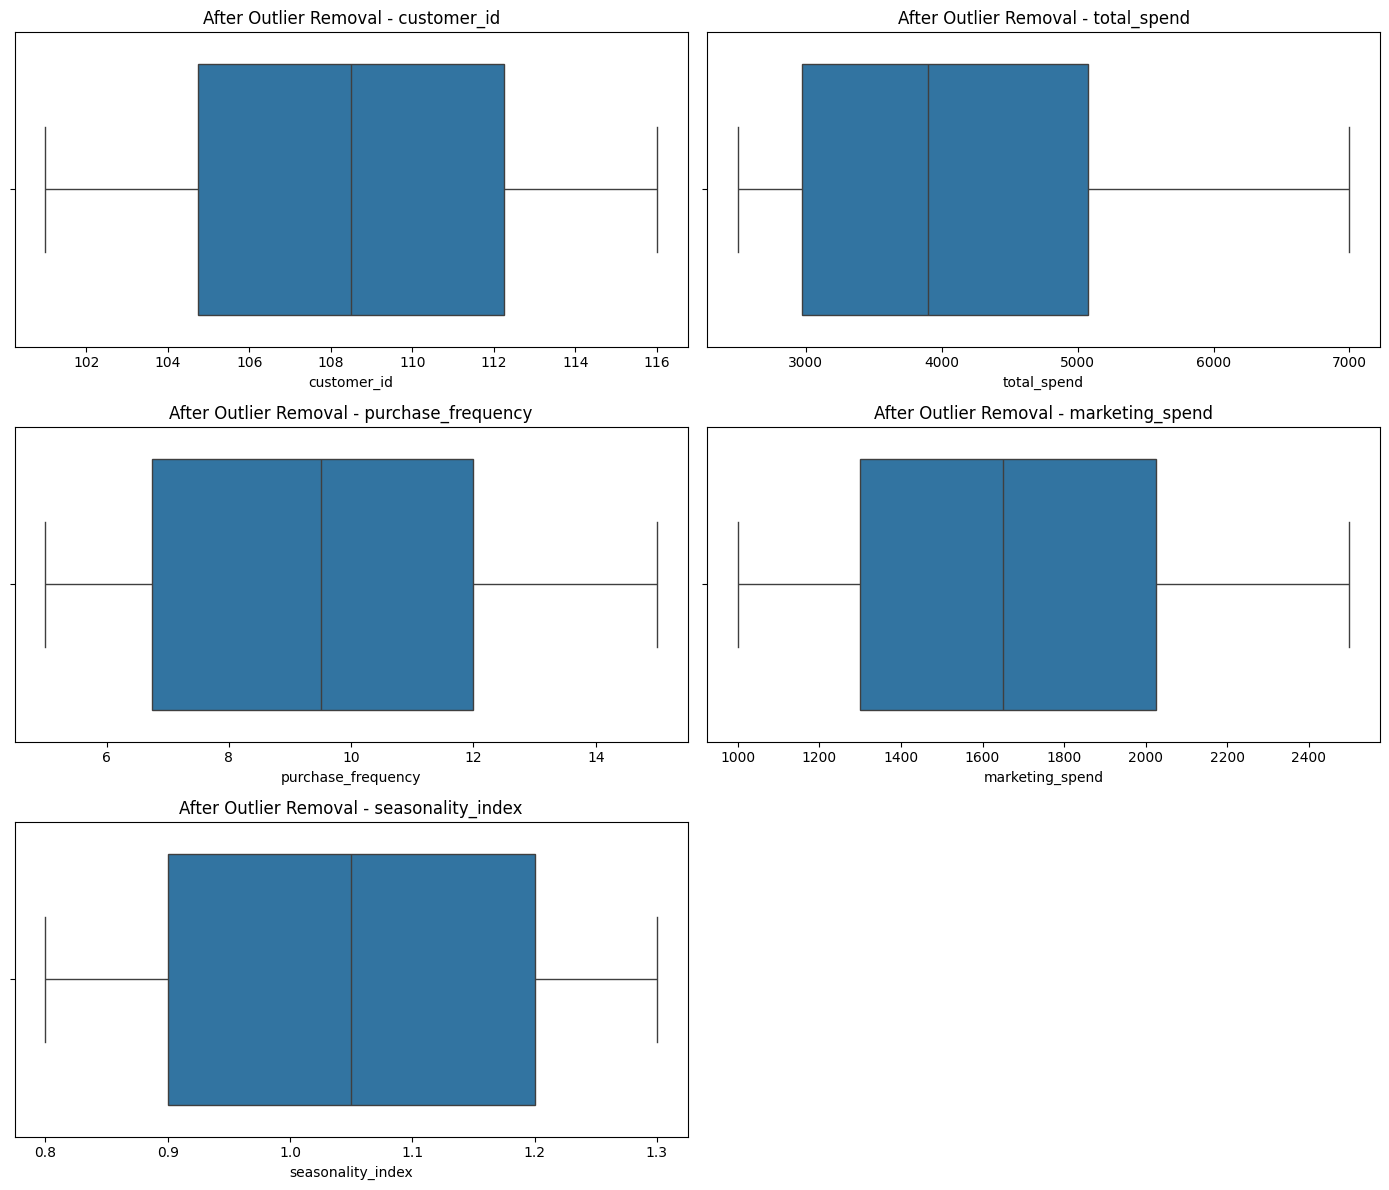

✅ Categorical variables standardized for consistency.
✅ Cleaned data saved as 'final_cleaned_data.csv'.


In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math

# -------------------------
# Step 0: Load dataset
# -------------------------
df = pd.read_csv('raw_sales_data.csv')  # Replace with your actual file name

# Normalize column names to lowercase for consistency
df.columns = df.columns.str.strip().str.lower()

# -------------------------
# Step 1: Handle Missing Values
# -------------------------

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

# Impute categorical columns with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("✅ Missing values handled using mean (numerical) and mode (categorical).")

# -------------------------
# Step 2: Detect and Remove Outliers (Z-score)
# -------------------------

# Visualize outliers before removal
n_cols = len(num_cols)
n_rows = math.ceil(n_cols / 2)

plt.figure(figsize=(14, 4 * n_rows))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Before Outlier Removal - {col}')
plt.tight_layout()
plt.show()

# Remove outliers using Z-score
z_scores = np.abs(zscore(df[num_cols]))
df_clean = df[(z_scores < 3).all(axis=1)].copy()  # Copy to avoid SettingWithCopyWarning

# Normalize column names again (to be safe)
df_clean.columns = df_clean.columns.str.strip().str.lower()

print(f"✅ Outliers removed. Rows reduced from {df.shape[0]} to {df_clean.shape[0]}.")

# Visualize after outlier removal
plt.figure(figsize=(14, 4 * n_rows))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, 2, i + 1)
    sns.boxplot(x=df_clean[col])
    plt.title(f'After Outlier Removal - {col}')
plt.tight_layout()
plt.show()

# -------------------------
# Step 3: Standardize Categorical Variables
# -------------------------

# Re-identify categorical columns after cleaning
cat_cols = df_clean.select_dtypes(include=['object']).columns

# Normalize categorical values
for col in cat_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()

# Replace inconsistent labels
if 'region' in df_clean.columns:
    df_clean['region'] = df_clean['region'].replace({
        'n': 'north', 's': 'south', 'e': 'east', 'w': 'west'
    })
    df_clean['region'] = df_clean['region'].str.title()

if 'churned' in df_clean.columns:
    df_clean['churned'] = df_clean['churned'].replace({
        'yes': 'yes', 'y': 'yes', 'no': 'no', 'n': 'no'
    })
    df_clean['churned'] = df_clean['churned'].str.capitalize()

print("✅ Categorical variables standardized for consistency.")

# -------------------------
# Step 4: Save Cleaned Data
# -------------------------
df_clean.to_csv('final_cleaned_data.csv', index=False)
print("✅ Cleaned data saved as 'final_cleaned_data.csv'.")

*Step 1: Linear Regression – Predict total_spend*

In [32]:
df = pd.read_csv('final_cleaned_data.csv')

# Ensure all column names are lowercase for consistency
df.columns = df.columns.str.strip().str.lower()


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
X = df[['marketing_spend', 'seasonality_index']]
y = df['total_spend']

# Drop rows with missing target
mask = y.notna()
X = X[mask]
y = y[mask]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction & Evaluation
y_pred = lr.predict(X_test)
print("\nLinear Regression Results")
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Linear Regression Results
R² Score: 0.793258175036579
MSE: 178185.61039034845


Step 2: Logistic Regression – Predict Customer Churn

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convert churned to binary if needed
df['churned'] = df['churned'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})

# Features and target
X = df[['total_spend', 'marketing_spend', 'purchase_frequency', 'seasonality_index']]
y = df['churned']

# Drop rows with missing target
mask = y.notna()
X = X[mask]
y = y[mask]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg.fit(X_train, y_train)

# Prediction & Evaluation
y_pred = log_reg.predict(X_test)
print("\n Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



 Logistic Regression Results
Accuracy: 1.0
Confusion Matrix:
 [[2 0]
 [0 2]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



*Step 3: Time Series Forecasting (ARIMA)*

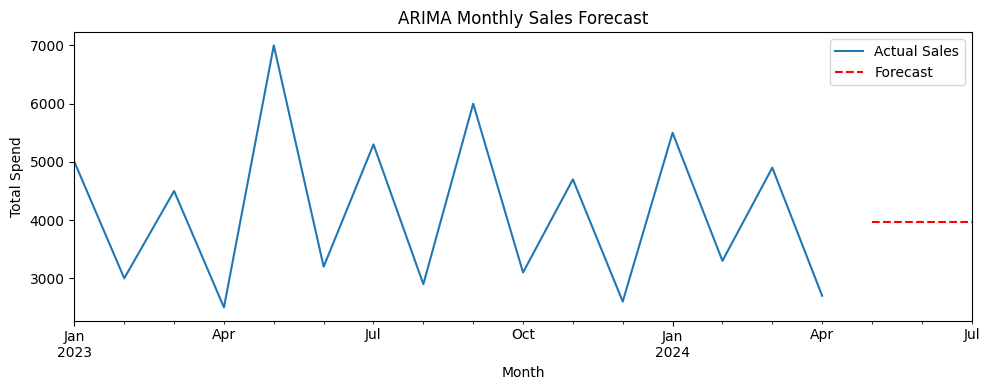

In [39]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Load cleaned data
df = pd.read_csv('final_cleaned_data.csv')
df.columns = df.columns.str.strip().str.lower()

# Step 2: Simulate monthly sales with synthetic months
monthly_sales = df[['total_spend']].copy()
monthly_sales['month'] = pd.date_range(start='2023-01-01', periods=len(df), freq='MS')
monthly_sales.set_index('month', inplace=True)
monthly_sales.columns = ['sales']
monthly_sales.index.freq = 'MS'  # Avoid frequency warning

# Step 3: Fit ARIMA model (adjust order if needed)
arima_model = ARIMA(monthly_sales['sales'], order=(0, 1, 1))
arima_fit = arima_model.fit(method_kwargs={"maxiter": 500})  # Reduce convergence issues

# Step 4: Forecast next 3 months
forecast = arima_fit.forecast(steps=3)
forecast.index = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')

# Step 5: Plot results
monthly_sales['sales'].plot(label='Actual Sales', figsize=(10, 4))
forecast.plot(label='Forecast', style='--', color='red')
plt.title('ARIMA Monthly Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Total Spend')
plt.legend()
plt.tight_layout()
plt.show()


*3. Statistical Analysis for Business Insights*

Step 1: ANOVA – Compare total_spend across different regions

In [42]:
# Load cleaned data
from scipy.stats import f_oneway
df = pd.read_csv('final_cleaned_data.csv')
df.columns = df.columns.str.strip().str.lower()\

# Group total_spend by region
regions = df['region'].unique()
groups = [df[df['region'] == r]['total_spend'] for r in regions]

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)
print("ANOVA Test: Total Spend by Region")
print("F-statistic:", f_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("✅ Statistically significant difference in sales across regions.")
else:
    print("❌ No significant difference in sales across regions.")


ANOVA Test: Total Spend by Region
F-statistic: 39.719626168224295
P-value: 1.6512569414092805e-06
✅ Statistically significant difference in sales across regions.


*Step 2: Hypothesis Testing – Impact of promotions on sales*

In [43]:
from scipy.stats import ttest_ind

# Simulate a 'promotion_applied' column (randomly for demo)
np.random.seed(42)
df['promotion_applied'] = np.random.choice([0, 1], size=len(df))  # 0 = No Promo, 1 = Promo

# Group by promotion status
promo_group = df[df['promotion_applied'] == 1]['total_spend']
no_promo_group = df[df['promotion_applied'] == 0]['total_spend']

# Perform independent t-test
t_stat, p_val = ttest_ind(promo_group, no_promo_group)
print("\n📊 Hypothesis Test: Promotions vs Total Spend")
print("T-statistic:", t_stat)
print("P-value:", p_val)

# Interpretation
if p_val < 0.05:
    print("✅ Promotions significantly impact sales.")
else:
    print("❌ No significant impact of promotions on sales.")



📊 Hypothesis Test: Promotions vs Total Spend
T-statistic: -0.9698897952179867
P-value: 0.3485602980432204
❌ No significant impact of promotions on sales.


*Step 3: Factor Analysis – Identify key drivers of purchase behavior*

In [45]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# Select numeric features for factor analysis
features = df[['total_spend', 'marketing_spend', 'purchase_frequency', 'seasonality_index']]
features_scaled = StandardScaler().fit_transform(features)

# Apply Factor Analysis (e.g., 2 latent factors)
fa = FactorAnalysis(n_components=2, random_state=0)
factors = fa.fit_transform(features_scaled)

# Loadings (contribution of each feature to each factor)
loadings = pd.DataFrame(fa.components_.T, columns=['Factor 1', 'Factor 2'], index=features.columns)
print("\n📊 Factor Analysis: Feature Loadings")
print(loadings)


📊 Factor Analysis: Feature Loadings
                    Factor 1  Factor 2
total_spend         0.972406 -0.054165
marketing_spend     0.998248 -0.013650
purchase_frequency  0.992566  0.065701
seasonality_index   0.967166 -0.068743


*4. Machine Learning for Customer Segmentation* 

In [47]:
# Load cleaned data
df = pd.read_csv('final_cleaned_data.csv')
df.columns = df.columns.str.strip().str.lower()

# Drop non-numeric or identifier columns
features = df[['total_spend', 'marketing_spend', 'purchase_frequency', 'seasonality_index']]

*Task 1: Decision Tree – Segment Customers Based on Purchasing Behavior*


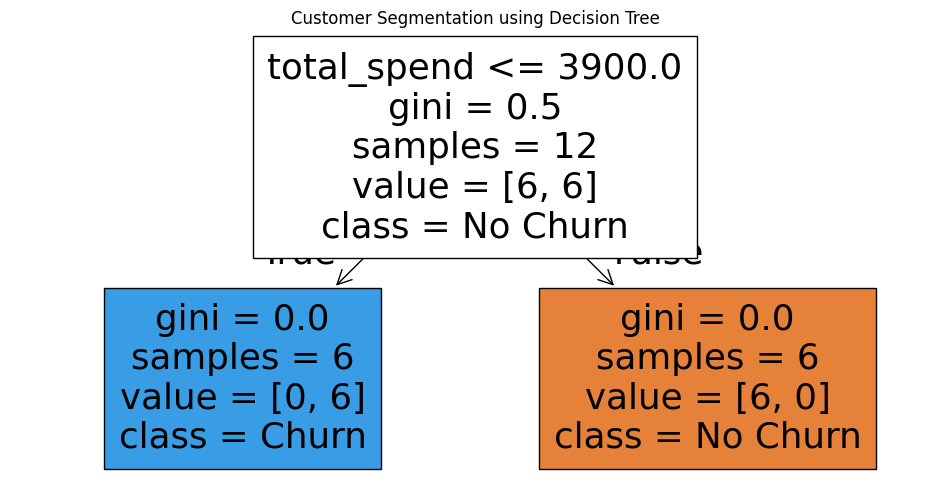

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encode churn as binary
df['churned'] = df['churned'].map({'Yes': 1, 'No': 0})

X = features
y = df['churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Plot tree
plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=X.columns, class_names=['No Churn', 'Churn'], filled=True)
plt.title("Customer Segmentation using Decision Tree")
plt.show()

*Task 2: K-Means Clustering – Group Customers by Spending Category*

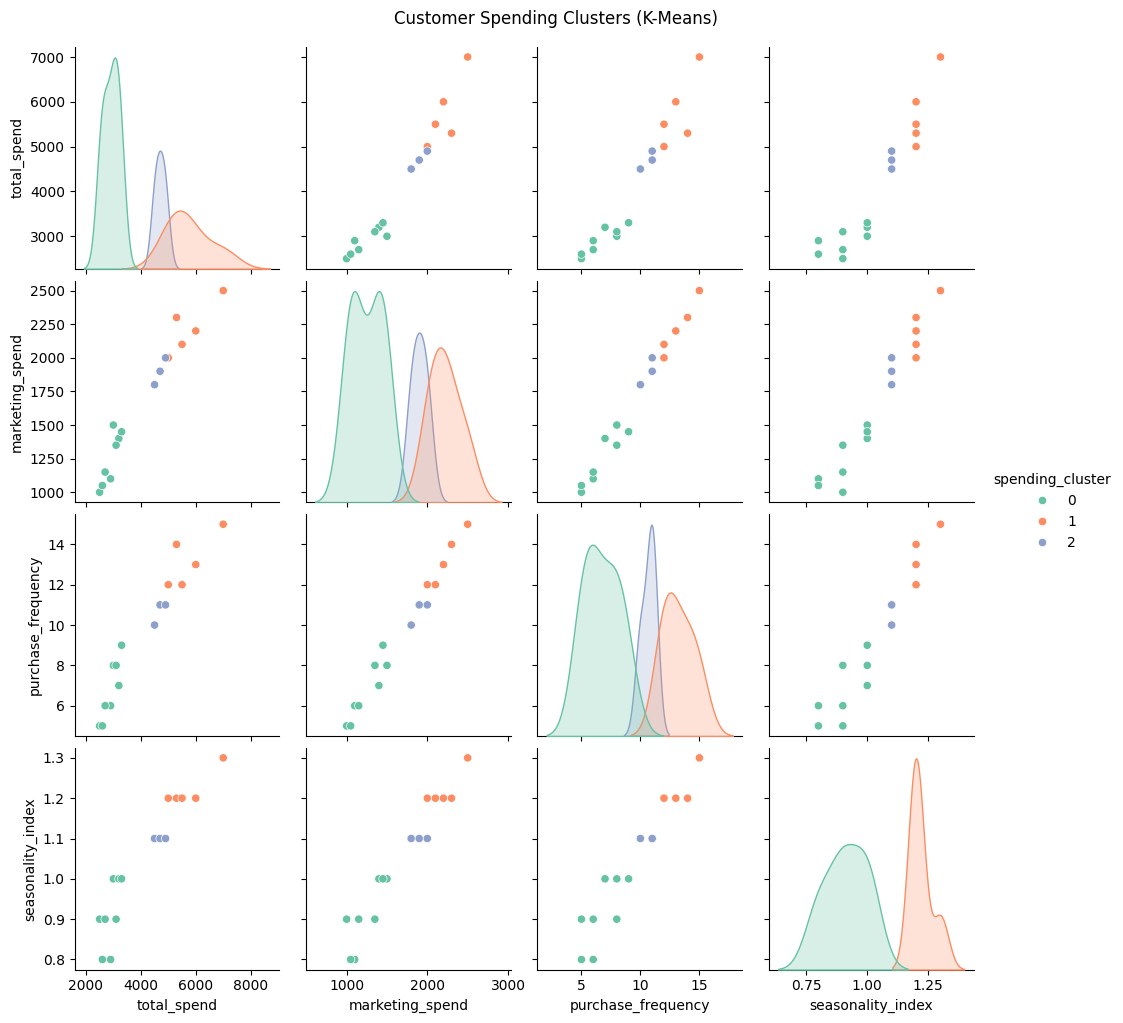

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster to DataFrame
df['spending_cluster'] = clusters

# Visualize clusters
sns.pairplot(df, vars=features.columns, hue='spending_cluster', palette='Set2')
plt.suptitle("Customer Spending Clusters (K-Means)", y=1.02)
plt.show()

*Task 3: Ensemble Learning – Predict Churn Using Random Forest and XGBoost*

In [50]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Reuse X and y from earlier

# --------- Random Forest ---------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("🌲 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


🌲 Random Forest Results:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [51]:

# --------- XGBoost ---------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("\n⚡ XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


⚡ XGBoost Results:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

